# CPO Datascience

This program is intended for use by the Portland State University Campus Planning Office (CPO).  

In [1]:
#Import required packages
import pandas as pd
import statsmodels as sm
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
def format_date1(df_date):
    """
    Splits Meeting times into Days of the week, Start time, and End time using regex
    """
    df_date['Days'] = df_date['Meeting_Times'].str.extract('([^\s]+)', expand=True)
    df_date['Start_Date'] = df_date['Meeting_Dates'].str.extract('([^\s]+)', expand=True)
    df_date['Start_Month'] = pd.to_datetime(df_date['Start_Date'][0:2], format='%b')
    df_date['End_Date'] = df_date['Meeting_Dates'].str.extract('(?<=-)(.*)(?= )', expand=True)
    df_date['End_Month'] = pd.to_datetime(df_date['End_Date'], format='%b')
    df_date['Start_Time'] = df_date['Meeting_Times'].str.extract('(?<= )(.*)(?=-)', expand=True)
    df_date['Start_Time'] = pd.to_datetime(df_date['Start_Time'], format='%H%M')
    df_date['End_Time'] = df_date['Meeting_Times'].str.extract('((?<=-).*$)', expand=True)
    df_date['End_Time'] = pd.to_datetime(df_date['End_Time'], format='%H%M')
    df_date['Duration_Hr'] = ((df_date['End_Time'] - df_date['Start_Time']).dt.seconds)/3600
    return df_date

In [5]:
def format_date(df_date):
    """
    Splits Meeting times into Days of the week, Start time, and End time using regex
    """
    df_date['Days'] = df_date['Meeting_Times'].str.extract('([^\s]+)', expand=True)
    df_date['Start_Date'] = df_date['Meeting_Dates'].str.extract('([^\s]+)', expand=True)
    #df_date['Start_Month'] = pd.to_datetime(df_date['Start_Date'][0:2], format='%b')
    df_date['End_Date'] = df_date['Meeting_Dates'].str.extract('(?<=-)(.*)(?= )', expand=True)
    #df_date['End_Month'] = pd.to_datetime(df_date['End_Date'], format='%b')
    df_date['Start_Time'] = df_date['Meeting_Times'].str.extract('(?<= )(.*)(?=-)', expand=True)
    df_date['Start_Time'] = pd.to_datetime(df_date['Start_Time'], format='%H%M')
    df_date['End_Time'] = df_date['Meeting_Times'].str.extract('((?<=-).*$)', expand=True)
    df_date['End_Time'] = pd.to_datetime(df_date['End_Time'], format='%H%M')
    df_date['Duration_Hr'] = ((df_date['End_Time'] - df_date['Start_Time']).dt.seconds)/3600
    return df_date

def format_xlist(df_xl):
    """
    revises % capacity calculations by using Max Enrollment instead of room capacity.  
    """
    df_xl['Cap_Diff'] = np.where(df_xl['Xlst'] != '', 
                                   df_xl['Max_Enrl'].astype(int) - df_xl['Actual_Enrl'].astype(int), 
                                   df_xl['Room_Capacity'].astype(int) - df_xl['Actual_Enrl'].astype(int)) 
    df_xl = df_xl.loc[df_xl['Room_Capacity'].astype(int) < 999]

    return df_xl


def plot_graph(x_vals, y_vals):
    """
    Plots the dataframe information.
    """
    x = range(len(x_vals))
    plt.figure(figsize=(20,10)) 
    N = 50
    colors = np.random.rand(N)
    sns.stripplot(x_vals, y_vals)
    plt.xticks(rotation=90)
    #plt.scatter(x, y_vals, alpha=0.5, )
    plt.show()

def OLS_operations(x_vals, y_vals):
    mod = sm.api.OLS(np.asarray(x_vals), np.asarray(y_vals))
    res = mod.fit()
    print(res.params)
    
def main():
    """
    Main program control flow.
    """
    #pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    df = pd.read_csv('data/PSU_master_classroom.csv')
    df = df.fillna('')

    df = format_date(df)
    # Avoid classes that only occur on a single day
    df = df.loc[df['Start_Date'] != df['End_Date']]
    df = df.loc[df['Online Instruct Method'] != 'Fully Online']
    #df = df.loc[df['Term'] == 201604]
    
    # Calculate number of days per week and treat Sunday condition
    df['Days_Per_Week'] = df['Days'].str.len()
    df['Room_Capacity'] = df['Room_Capacity'].apply(lambda x: x if (x != 'No Data Available') else 0)
    
    df_cl = format_xlist(df)
    dep_var = df_cl['Cap_Diff'] # Our dependent variable
    test_var = df_cl['Dept'] # Changeable test variables
    
    plot_graph(test_var, dep_var)
    #OLS_operations(test_var, dep_var)
    



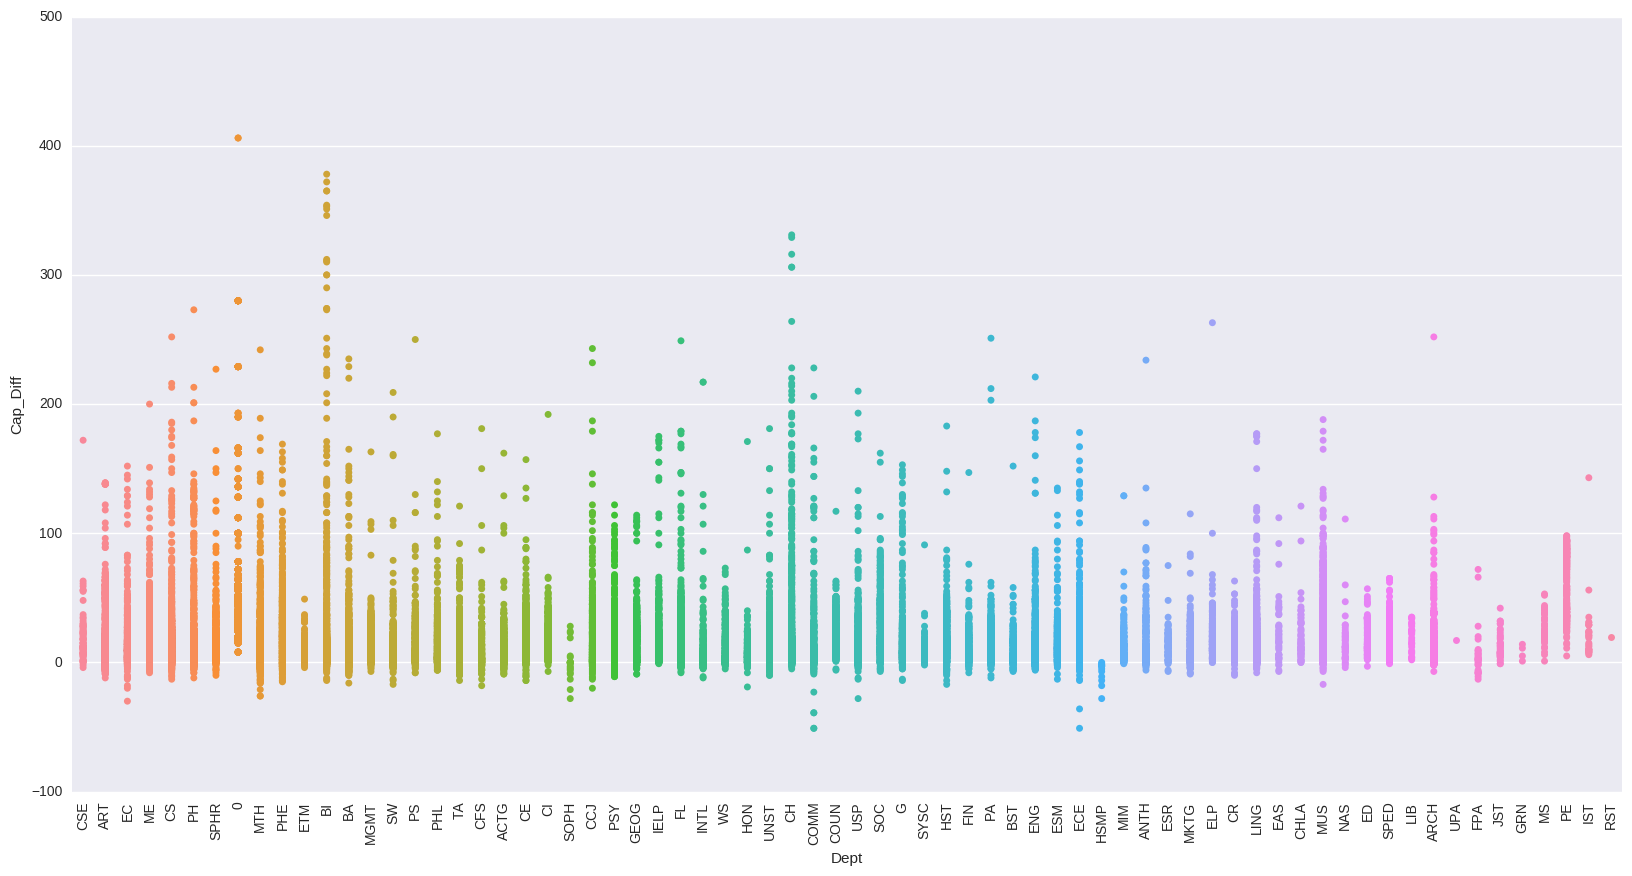

In [4]:
main()